<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA4P2S12_ImageCaptionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov 21 14:44:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install torch numpy matplotlib sacrebleu

In [2]:
!pip install sacrebleu


     |████████████████████████████████| 71kB 5.6MB/s 


In [3]:
!pip install torch==1.5.0+cu92 torchvision==0.6.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 674kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [4]:
!pip install boto3
# !pip install git+git://github.com/pytorch/text spacy 
# !python -m spacy download en
# !python -m spacy download de

     |████████████████████████████████| 133kB 10.9MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 6.9MB 16.0MB/s 
     |████████████████████████████████| 143kB 43.8MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Prep Stage

In [5]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace
import sacrebleu
import os
import sys
import io
import glob
import boto3
# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp -Rf /content/drive/My\ Drive/EVA4/P2S11/Pytorch-Captioning /content/
#!git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning.git

In [8]:
%load_ext autoreload
%autoreload 2
sys.path.append("/content/Pytorch-Captioning")

sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")

In [10]:
!cp /content/drive/My\ Drive/EVA4/P2S11/caption_datasets.zip /content/caption_datasets.zip && unzip -q /content/caption_datasets.zip
!mkdir ~/.kaggle && cp /content/drive/My\ Drive/EVA4/P2S11/kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

replace dataset_coco.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_flickr30k.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_flickr8k.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
!pip install -q kaggle

In [27]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:32<00:00, 37.4MB/s]
100% 8.16G/8.16G [03:32<00:00, 41.2MB/s]


In [28]:
!unzip -q /content/flickr-image-dataset.zip

In [ ]:
glob.glob("/content/flickr30k_images/flickr30k_images/*")[0]

'/content/flickr30k_images/flickr30k_images/4693817697.jpg'

In [29]:
%autoreload 1
!python /content/Pytorch-Captioning/create_input_files.py


Reading TRAIN images and captions, storing to file...

100% 29000/29000 [04:37<00:00, 104.40it/s]

Reading VAL images and captions, storing to file...

100% 1014/1014 [00:10<00:00, 94.61it/s] 

Reading TEST images and captions, storing to file...

100% 1000/1000 [00:10<00:00, 92.62it/s]


In [ ]:
!du -ch /content/flickr30k_images/*hdf5

188M	/content/flickr30k_images/TEST_IMAGES_flickr30k_5_cap_per_img_5_min_word_freq.hdf5
5.4G	/content/flickr30k_images/TRAIN_IMAGES_flickr30k_5_cap_per_img_5_min_word_freq.hdf5
191M	/content/flickr30k_images/VAL_IMAGES_flickr30k_5_cap_per_img_5_min_word_freq.hdf5
5.7G	total


In [11]:
!cp /content/drive/My\ Drive/EVA4/P2S11/checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar /content
!cp  /content/drive/My\ Drive/EVA4/P2S11/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar /content/

## Model definitions

In [30]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention
from datasets import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu

# Data parameters
data_folder = '/content/flickr30k_images'  # folder with data files saved by create_input_files.py
data_name = 'flickr30k_5_cap_per_img_5_min_word_freq'  # base name shared by data files

# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = False  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

# Training parameters
start_epoch = 0
epochs = 80  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 32
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # path to checkpoint, None if none

In [31]:
def my_train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """
    Performs one epoch's training.

    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        #print(type(targets), type(scores))
        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def my_validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.

    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
            #print(type(targets), type(scores))
            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4



In [32]:
"""
Training and validation.
"""
%load_ext autoreload
%autoreload 1
global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map
from utils import *

# Read word map
word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

checkpoint="/content/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model Training

In [17]:


# Initialize / load checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                    embed_dim=emb_dim,
                                    decoder_dim=decoder_dim,
                                    vocab_size=len(word_map),
                                    dropout=dropout)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                            lr=decoder_lr)
    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                lr=encoder_lr)

# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    my_train(train_loader=train_loader,
            encoder=encoder,
            decoder=decoder,
            criterion=criterion,
            encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer,
            epoch=epoch)

    # One epoch's validation
    recent_bleu4 = my_validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion)

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch: [9][0/4532]	Batch Time 1.882 (1.882)	Data Load Time 0.789 (0.789)	Loss 3.2382 (3.2382)	Top-5 Accuracy 75.917 (75.917)
Epoch: [9][100/4532]	Batch Time 0.852 (0.838)	Data Load Time 0.000 (0.008)	Loss 3.0849 (3.1686)	Top-5 Accuracy 78.788 (76.189)
Epoch: [9][200/4532]	Batch Time 0.919 (0.865)	Data Load Time 0.000 (0.004)	Loss 3.1482 (3.1439)	Top-5 Accuracy 76.734 (76.483)
Epoch: [9][300/4532]	Batch Time 0.912 (0.873)	Data Load Time 0.000 (0.003)	Loss 3.1330 (3.1432)	Top-5 Accuracy 76.310 (76.520)
Epoch: [9][400/4532]	Batch Time 0.900 (0.880)	Data Load Time 0.000 (0.002)	Loss 3.4003 (3.1443)	Top-5 Accuracy 73.455 (76.490)
Epoch: [9][500/4532]	Batch Time 1.002 (0.884)	Data Load Time 0.000 (0.002)	Loss 3.3529 (3.1473)	Top-5 Accuracy 72.078 (76.436)
Epoch: [9][600/4532]	Batch Time 0.886 (0.887)	Data Load Time 0.000 (0.001)	Loss 2.9104 (3.1501)	Top-5 Accuracy 79.310 (76.368)
Epoch: [9][700/4532]	Batc

KeyboardInterrupt: ignored

In [ ]:
"""
Training and validation.
"""
%load_ext autoreload
%autoreload 1
global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map
from utils import *

# Read word map
word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)

checkpoint="/content/checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar"

# Initialize / load checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim,
                                    embed_dim=emb_dim,
                                    decoder_dim=decoder_dim,
                                    vocab_size=len(word_map),
                                    dropout=dropout)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                            lr=decoder_lr)
    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                            lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                                lr=encoder_lr)

# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
    batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 2 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if fine_tune_encoder:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    my_train(train_loader=train_loader,
            encoder=encoder,
            decoder=decoder,
            criterion=criterion,
            encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer,
            epoch=epoch)

    # One epoch's validation
    recent_bleu4 = my_validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion)

    # Check if there was an improvement
    is_best = recent_bleu4 > best_bleu4
    best_bleu4 = max(recent_bleu4, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

DECAYING learning rate.
The new learning rate is 0.000320

Epoch: [16][0/4532]	Batch Time 1.184 (1.184)	Data Load Time 0.207 (0.207)	Loss 2.8491 (2.8491)	Top-5 Accuracy 80.365 (80.365)
Epoch: [16][100/4532]	Batch Time 0.877 (0.915)	Data Load Time 0.000 (0.002)	Loss 2.9529 (2.7301)	Top-5 Accuracy 79.679 (82.406)
Epoch: [16][200/4532]	Batch Time 0.944 (0.911)	Data Load Time 0.000 (0.001)	Loss 2.9115 (2.7409)	Top-5 Accuracy 78.870 (82.246)
Epoch: [16][300/4532]	Batch Time 0.863 (0.910)	Data Load Time 0.000 (0.001)	Loss 2.6633 (2.7426)	Top-5 Accuracy 83.123 (82.170)
Epoch: [16][400/4532]	Batch Time 0.873 (0.908)	Data Load Time 0.000 (0.001)	Loss 2.5614 (2.7454)	Top-5 Accuracy 86.091 (82.118)
Epoch: [16][500/4532]	Batch Time 0.881 (0.907)	Data Load Time 0.000 (0.001)	Loss 2.7124 (2.7445)	Top-5 Accuracy 82.033 (82.087)
Epoch: [16][600/4532]	Batch Time 0.967 (0.905)	Data Load Time 0.000 (0.001)	Loss 2.875

### Max Score
 * LOSS - 3.696, TOP-5 ACCURACY - 69.755, BLEU-4 - 0.17135100960071897


## Inferencing

In [46]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                            #   embedding_layer, 
                            #   attention_layer,

def caption_image_beam_search(encoder, 
                              decoder, 
                              image_path, 
                              word_map, 
                              beam_size=3,
                              device=torch.device("cpu")):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    #img = imread(image_path)
    pil_img = Image.open(image_path)
    pil_img = pil_img.resize((256, 256))
    img = np.asarray(pil_img)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    #img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    #h, c = decoder.init_hidden_state(encoder_out)
    mean_encoder_out = encoder_out.mean(dim=1)
    h = decoder.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
    c = decoder.init_c(mean_encoder_out)
    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        #print(k_prev_words)
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
        #embeddings = embedding_layer(k_prev_words).squeeze(1)  # (s, embed_dim)
        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
        #awe, alpha = attention_layer(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    pred_caption = " ".join(words[1:-1])
    print("Predicted caption:",pred_caption)
    #return words[1:-1]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

/content/flickr30k_images/flickr30k_images/7942450860.jpg


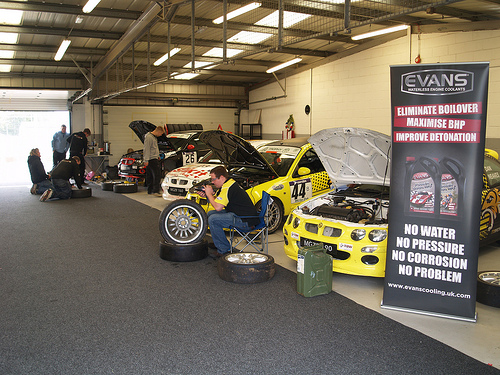

In [34]:
image_path = glob.glob("/content/flickr30k_images/flickr30k_images/*.*")[3412]
print(image_path)
Image.open(image_path)


In [41]:
myargs = {"model":"/content/BEST_checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar",
          "img":image_path,
          "word_map":"/content/flickr30k_images/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json",
          "smooth":True,
          "beam_size":5,
          }

In [39]:
%matplotlib inline
!python /content/Pytorch-Captioning/caption.py -i "/content/flickr30k_images/flickr30k_images/7942450860.jpg" \
 --model "/content/checkpoint_flickr30k_5_cap_per_img_5_min_word_freq.pth.tar" \
 --word_map "/content/flickr30k_images/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json" \
 -b 1

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Predicted Caption: a man in a black shirt and jeans is sitting in a car with a yellow car and a yellow car
<Figure size 640x480 with 23 Axes>


Predicted caption: a group of people are sitting in front of a yellow car


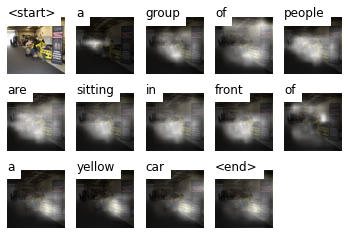

In [47]:
# Load model
checkpoint = torch.load(myargs["model"], map_location=str(device))
decoder = checkpoint['decoder']
#decoder = decoder.to(device)
decoder = decoder.to(torch.device("cpu"))
#decoder.eval()
encoder = checkpoint['encoder']
#encoder = encoder.to(device)
encoder = encoder.to(torch.device("cpu"))

#encoder.eval()

# Load word map (word2ix)
with open(myargs["word_map"], 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, myargs["img"], word_map, myargs["beam_size"])
#print(seq)
alphas = torch.FloatTensor(alphas)

# Visualize caption and attention of best sequence
visualize_att(myargs["img"], seq, alphas, rev_word_map, False)

In [19]:
encoder = encoder.to("cpu")

In [21]:
decoder = decoder.to("cpu")

In [20]:
torch.save(encoder, "S12_encoder.pt")

In [22]:
torch.save(decoder, "S12_decoder.pt")

## Saved model pushed to AWS S3

In [26]:
!pip install boto3

In [23]:
import os
import sys
import glob


In [24]:
sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")

In [23]:
glob.glob("./*pt")

['./S12_encoder.pt', './S12_decoder.pt']

In [24]:
from RekogNizer import awsutils

for saved_model in glob.glob("./*pt"):
    awsutils.upload_model_to_s3('rekog-eva4s1',saved_model,os.path.basename(saved_model))

In [25]:
import boto3
S3_BUCKET='rekog-eva4s1'
s3 = boto3.client('s3')
s3_res = boto3.resource('s3')
bucket = s3_res.Bucket(S3_BUCKET)

model_name='S12_decoder.pt'
obj = s3.get_object(Bucket=S3_BUCKET, Key=model_name)
bytestream = io.BytesIO(obj['Body'].read() )
print("Loading Model {}".format(model_name))
#traced_model = torch.jit.load(bytestream)
decoder_new = torch.load(bytestream) ### This will load only the model_state_dict
#traced_model.eval()
#MODELS_DICT[key] = model
print( "Models {} Loaded".format(decoder_new))

Loading Model S12_decoder.pt
Models DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(7003, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=7003, bias=True)
) Loaded


In [21]:
decoder.eval()

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(7003, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=7003, bias=True)
)

## Inferencing on the deployed model

/content/flickr30k_images/flickr30k_images/3826378639.jpg


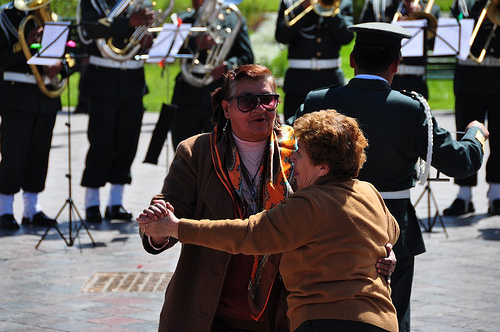

In [49]:
image_path = glob.glob("/content/flickr30k_images/flickr30k_images/*.*")[3312]
print(image_path)
Image.open(image_path)


In [51]:
!curl -X POST \
  https://3kpbfogkt0.execute-api.ap-south-1.amazonaws.com/dev/classify \
  -H 'cache-control: no-cache' \
  -H 'content-type: multipart/form-data; boundary=----WebKitFormBoundary7MA4YWxkTrZu0gW' \
  -H 'postman-token: 862f22ee-dd51-c0e1-3143-9da4495a63b9' \
  -F 'file=@/content/flickr30k_images/flickr30k_images/3826378639.jpg'

{"file": "None", "predicted": "a man and a woman are dancing"}